In [2]:
import os
import geopandas as geopd
import rasterio 
from pathlib import Path
import pandas as pd
import numpy as np

np.seterr(divide='ignore', invalid='ignore')
os.chdir("/home/me/workspace/det_remota/trabalho_final")

In [3]:
%conda install jinja2 tabulate

Channels:
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
TRAINING_POLY_PATH = Path("data/qgis_outputs/training_data.shp")
training_gdf = geopd.read_file(TRAINING_POLY_PATH)
training_gdf["area"] = training_gdf.geometry.area
area_vec = training_gdf.groupby('lulc').area.sum()/10_000
count_vec = training_gdf.groupby('lulc').area.count()
print(pd.DataFrame({
    'N. Polygons': count_vec,
    'Area (ha)': area_vec
}).to_markdown())

| lulc             |   N. Polygons |   Area (ha) |
|:-----------------|--------------:|------------:|
| aquaculture      |          1206 |     618.223 |
| farming          |            19 |     639.784 |
| forest           |             6 |    1247.59  |
| non_vegetated    |            23 |    4990.48  |
| river_lake_ocean |             9 |     286.562 |


In [5]:
TRAINING_RASTER_PATH = Path("data/sentinel2/preprocessed/equalized_mosaics/2017_8.tiff")

training_raster = rasterio.open(TRAINING_RASTER_PATH)
training_raster.shape

(7884, 13797)

In [6]:
import rasterio.mask

def get_mask_for_row(idx: int):
    id, lulc, geometry, area = training_gdf.iloc[idx, :]
    
    masked, _ = rasterio.mask.mask(
        training_raster, 
        [geometry], 
        filled=False,
        crop=True,
    )
    
    return {
        "row_idx": idx,
        "id": id,
        "lulc": lulc,
        "geometry": geometry,
        "raster": masked
    }

masked_rasters = [get_mask_for_row(x) for x in range(training_gdf.shape[0])]
masked_rasters[0]

{'row_idx': 0,
 'id': 5,
 'lulc': 'non_vegetated',
 'geometry': <POLYGON ((-7018419.431 -1106262.283, -7017899.449 -1104869.086, -7017066.68...>,
 'raster': masked_array(
   data=[[[--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          ...,
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --]],
 
         [[--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          ...,
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --]],
 
         [[--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          ...,
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --],
          [--, --, --, ..., --, --, --]],
 
         ...,
 
         [[--, --, --

In [7]:
import numpy as np
import pandas as pd

def summarize_raster_dict(mask_dict: dict):
    raster = mask_dict["raster"]

    def extract_band_values(band_idx):
        band_values = pd.DataFrame(raster[band_idx]).values.reshape(-1)
        return pd.DataFrame({
            "band": band_idx+1,
            "value": band_values
        })

    pixels_df = pd.concat([
        extract_band_values(x)
        for x in range(10)
    ], axis=0)
    pixels_df["lulc"] = mask_dict["lulc"]
    pixels_df["id"] = mask_dict["id"]
    pixels_df["row_idx"] = mask_dict["row_idx"]
    pixels_df.reset_index(inplace=True, drop=True)
    
    return pixels_df
    

poly_stats_df = pd.concat([
    summarize_raster_dict(x)
    for x in masked_rasters
], axis=0)
poly_stats_df.reset_index(inplace=True, drop=True)
poly_stats_df

,band,value,lulc,id,row_idx
0,1,NaN,non_vegetated,5,0
1,1,NaN,non_vegetated,5,0
2,1,NaN,non_vegetated,5,0
3,1,NaN,non_vegetated,5,0
4,1,NaN,non_vegetated,5,0
...,...,...,...,...,...
14548565,10,0.0,aquaculture,1,1262
14548566,10,0.0,aquaculture,1,1262
14548567,10,0.0,aquaculture,1,1262
14548568,10,0.0,aquaculture,1,1262


In [8]:
poly_stats_df.drop(index=poly_stats_df.index[poly_stats_df.value.isna()],
                   inplace=True)


In [9]:
(poly_stats_df.groupby("lulc").band.count()/10).astype(int)

lulc
aquaculture          61415
farming              62102
forest              121117
non_vegetated       484681
river_lake_ocean     27821
Name: band, dtype: int64

Text(0.5, 1.0, 'As margens de erro contém 90% das observações')

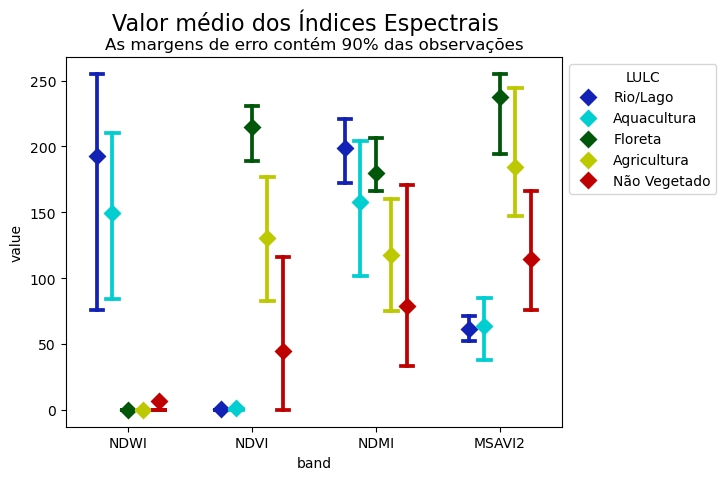

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

def rename_index_band(band_idx):
    if band_idx == 7:
        return "NDMI" 
    if band_idx == 8:
        return "MSAVI2" 
    if band_idx == 9:
        return "NDWI" 
    if band_idx == 10:
        return "NDVI" 
    return None


def rename_lulc(x):
    if x=='river_lake_ocean':
        return 'Rio/Lago'
    if x=='aquaculture':
        return 'Aquacultura'
    if x=='forest':
        return 'Floreta'
    if x=='farming':
        return 'Agricultura'
    return 'Não Vegetado'

index_stats_df = poly_stats_df.loc[poly_stats_df.band>6, :].copy()
index_stats_df.band = [rename_index_band(x) for x in index_stats_df.band]
index_stats_df['LULC'] = [rename_lulc(x) for x in index_stats_df.lulc]

ax = sns.pointplot(index_stats_df, x='band', y='value', hue='LULC',
                   dodge=0.5, 
                   estimator="mean",
                   errorbar=lambda x: np.quantile(x, (0.05, 0.95)),
                   capsize=0.1,
                   linestyles="none",
                   markers="D",
                   order=["NDWI", "NDVI", "NDMI", "MSAVI2"],
                   hue_order=["Rio/Lago", "Aquacultura", "Floreta", "Agricultura", "Não Vegetado",],
                   palette={
                       'Rio/Lago': "#1222b5",
                       'Aquacultura': "#00ced1",
                       'Floreta': "#005709",
                       'Agricultura': "#bcc900",
                       'Não Vegetado': "#bf0000"   
                   }
                )
sns.move_legend(
    ax,
    "upper left", 
    bbox_to_anchor=(1, 1)
)
plt.suptitle('Valor médio dos Índices Espectrais', fontsize=16, x=0.5)
plt.title('As margens de erro contém 90% das observações', fontsize=12, x=0.5)

In [22]:
index_stats_df.loc[index_stats_df.lulc =='forest'].loc[index_stats_df.band =='NDVI'].value.quantile(0.01)

153.0